We take the 2019 hansen landsat mosaic along with UAVSAR quad-pol data (to simulate NISAR) over the gulfcoast and turn it into a datacube.

Ingredients:

1. A shapefile indicating a rough Region of Interest (ROI)
2. The hansen landsat [mosaic](https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.7.html) with:
    + band 1 = Landsat 3 / blue 
    + band 2 = Landsat 4 / green
    + band 3 = Landsat 5 / red
    + band 4 = Landsat 7 / near infared
    
   
3. UAVSAR HH, HV, and VV backscatter imagery.

This is the most efficient way we though of though this rasterio [example](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html) could possible make these scripts use less RAM. Overall, the general contour of the approach would be the same would be the same.

In [1]:
import rasterio
from pathlib import Path
from rscube import reproject_arr_to_match_profile, rasterize_shapes_to_array, get_cropped_profile
import geopandas as gpd
import numpy as np
from tqdm import tqdm
from itertools import starmap
import matplotlib.pyplot as plt

## Inspecting the ROI

We first open the shape file with the ROI.

<AxesSubplot:>

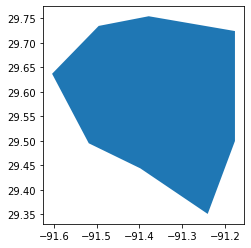

In [2]:
df = gpd.read_file('data/ROI')
df.plot()

We want to take the bound  of the above shape and use it to reproject the data into roughly the same area.

In [3]:
df.bounds

,minx,miny,maxx,maxy
0,-91.604631,29.351072,-91.176264,29.753899


In this case, the coordinate reference system (CRS) of the shapefile and rasters happen to be the same. If the shapefile had a different CRS, we would have to reproject it collecting the crs from the rasters below and then `df = df.to_crs(crs)`.

In [4]:
with rasterio.open('data/full_coverage/UAVSAR_RTC_hh_20190620_rabarsar.tif') as ds:
    profile = ds.profile
    crs = dict(ds.crs)
crs

{'init': 'epsg:4326'}

Now, we take the bounds and find the array slices using rasterio.

In [5]:
rows, cols = rasterio.transform.rowcol(profile['transform'], 
                                       [df.bounds.minx, df.bounds.maxx], 
                                       [df.bounds.maxy, df.bounds.miny])
rows, cols

([-1356, 2672], [1354, 5637])

We could get negative values (as we do above), so we make sure that our slices begin and end within the bounds of our array.

In [6]:
sy = np.s_[max(rows[0], 0): min(rows[1], profile['height'])]
sx = np.s_[max(cols[0], 0): min(cols[1], profile['width'])]
sy, sx

(slice(0, 2672, None), slice(1354, 5637, None))

Below, our geo-profile will allow us to reproject the other datasets into this reference frame.

In [7]:
cropped_profile = get_cropped_profile(profile, sx, sy)
cropped_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 4283, 'height': 2672, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001, 0.0, -91.60464999999999,
       0.0, -0.0001, 29.618350000000003), 'tiled': False, 'interleave': 'band'}

## Reading and Reprojecting the Rasters

Now, we write very simple functions to apply to each of our rasters. One function to read and another to reproject.

In [8]:
REFERENCE_PROFILE = cropped_profile.copy()

def read_one(path, k=1):
    with rasterio.open(path) as ds:
        arr = ds.read(k)
    return arr

def reproject_one(arr, src_profile):
    img_r, _ = reproject_arr_to_match_profile(arr, src_profile, REFERENCE_PROFILE)
    return img_r

In this step, we read each of the raster datasets. Note the hansen dataset is very large and will take both time and RAM.

In [9]:
arrays = [read_one('data/full_coverage/Hansen_GFC-2019-v1.7_last_30N_100W.tif', k) for k in tqdm(range(1, 5))]
arrays += [read_one(path) for path in tqdm(Path('data/full_coverage/').glob('UAVSAR*.tif'), total=3)]

100%|██████████| 3/3 [00:00<00:00,  6.85it/s]


We want to reproject the above datasets. We will collect the source metadata from each dataset.

In [10]:
with rasterio.open('data/full_coverage/Hansen_GFC-2019-v1.7_last_30N_100W.tif') as ds:
    hansen_profile = ds.profile
    # The original hansen dataset has 4 bands (i.e. `count = 4`), but we are saving each band
    # as it's own raster.
    hansen_profile['count'] = 1
with rasterio.open('data/full_coverage/UAVSAR_RTC_hh_20190620_rabarsar.tif') as ds:
    uavsar_profile = ds.profile
    
profiles = [hansen_profile] * 4 + [uavsar_profile] * 3

In [11]:
arrs_r = list(starmap(reproject_one, zip(tqdm(arrays), profiles)))

100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


## Masking

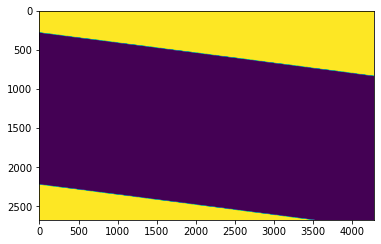

In [12]:
masks = [np.isnan(arr)[0, ...] for arr in arrs_r]
mask = np.logical_or.reduce(masks)
plt.imshow(mask)

Now, we also want to use the ROI shapefile to mask. To do this, we need to "rasterize" the shapefile.

In [13]:
df.geometry.tolist

<bound method IndexOpsMixin.tolist of 0    POLYGON ((-91.37826 29.75390, -91.17626 29.723...
Name: geometry, dtype: geometry>

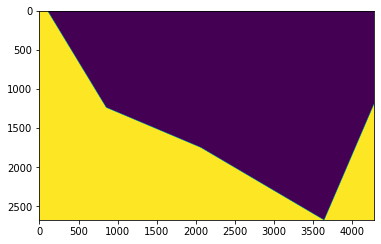

In [14]:
roi_mask = rasterize_shapes_to_array(df.geometry.tolist(), 
                                     [1] * df.shape[0], 
                                     cropped_profile)
roi_mask = ~roi_mask.astype(bool)
plt.imshow(roi_mask)

If we wanted to include this specific mask, we would uncomment the second line below. However, we are going to leave our rasters simply cropped and not further mask them.

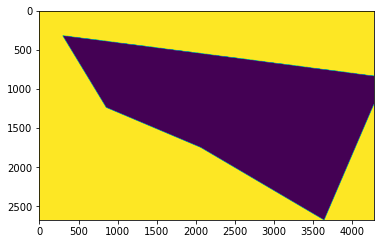

In [15]:
plt.imshow(mask | roi_mask)
# mask = mask | roi_mask

To ensure that all the data has the `nodata` areas, we mask each raster according to the mask above.

In [16]:
def mask_arr(arr):
    arr_ = arr.astype(np.float32)
    arr_[0,...][mask] = np.nan
    return arr_

arrs_r_masked = list(map(mask_arr, arrs_r))

## Writing the datacube

In [17]:
def write_one(arr, dest_path):
    with rasterio.open(dest_path, 'w', **REFERENCE_PROFILE) as ds:
        ds.write(arr.astype(np.float32))
    return dest_path

In [18]:
dest_dir = Path('data/datacube_ROI')
dest_dir.mkdir(exist_ok=True, parents=True)

In [19]:
dest_paths = ([f'hansen_{k}.tif' for k in [3, 4, 5, 7]] 
              + [path.name for path in Path('data/full_coverage/').glob('UAVSAR*.tif')])
dest_paths = [dest_dir/path for path in dest_paths]

In [20]:
list(starmap(write_one, zip(tqdm(arrs_r_masked), dest_paths)))

100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


[PosixPath('data/datacube_ROI/hansen_3.tif'),
 PosixPath('data/datacube_ROI/hansen_4.tif'),
 PosixPath('data/datacube_ROI/hansen_5.tif'),
 PosixPath('data/datacube_ROI/hansen_7.tif'),
 PosixPath('data/datacube_ROI/UAVSAR_RTC_hh_20190620_rabarsar.tif'),
 PosixPath('data/datacube_ROI/UAVSAR_RTC_vv_20190620_rabarsar.tif'),
 PosixPath('data/datacube_ROI/UAVSAR_RTC_hv_20190620_rabarsar.tif')]